### Create MapBox tiles (mbtiles) 
Based on [this Sci-team notebook](https://github.com/Vizzuality/sci_team_data_bank/blob/master/Projects/usa-resilience-opportunity-map/processing/create_MBTiles.ipynb)

If not installed, install tippecanoe in terminal with: $brew install tippecanoe

## python libraries

In [2]:
import pandas as pd 
import geopandas as gpd
import getpass
import requests
import shapely.wkb 
import subprocess

## Utils

In [3]:
def create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel"):
    """
    Use tippecanoe to create a MBTILE at dest_path from source_path.
    layer_name is used for the name of the layer in the MBTILE.
    Regex file path (/*.geojson) is supported for source_path.
    """
    cmd = f"tippecanoe -o {dest_path} -l {layer_name} {opts} {source_path}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
    print("Finished processing")

## Read data
The data includes the tourism regions and other polygon and point contextual data (airports, ski resorts, tourism centers, etc)
* All layers must be sjoined with the tourism-regions layer to make sure we can filter on the map  
* The names of the tourism regions are modified to match the syntax used in the API

### Tourism regions

In [5]:
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP.geojson')
#region

In [6]:
rename = {'Vancouver Island':'vancouver_island',
         'Vancouver, Coast and Mountains':'vancouver_coast_and_mountains',
         'Thompson Okanagan':'thompson_okanagan',
         'Kootenay Rockies':'kootenay_rockies',
         'Cariboo Chilcotin Coast':'cariboo_chilcotin_coast',
         'Northern British Columbia':'northern_british_columbia'}
region.replace({'TOURISM_REGION_NAME':rename}, inplace =True)

#Save first time
#region.to_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson', driver="GeoJSON")

### Contextual layers
+ Ski resorts
+ First Nations community locations
+ First Nations business list
+ Wildlife habitats

In [8]:
layers = {'ski_resorts': '../data/raw/GSR_SKI_RESORTS_SV.geojson',
         'first_nations_communities':'../data/raw/FN_COMMUNITY_LOCATIONS_SP.geojson',
         'first_nations_business':'../data/raw/GSR_INDIGENOUS_BUSINESSES_SV.geojson',
         'wildlife_habitats':'../data/raw/WCP_WILDLIFE_HABITAT_AREA_POLY.geojson'}

In [20]:
layers[layer].split('/')[3].split('.')[0]

'WCP_WILDLIFE_HABITAT_AREA_POLY'

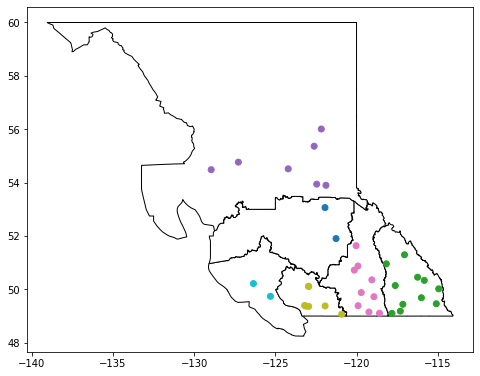

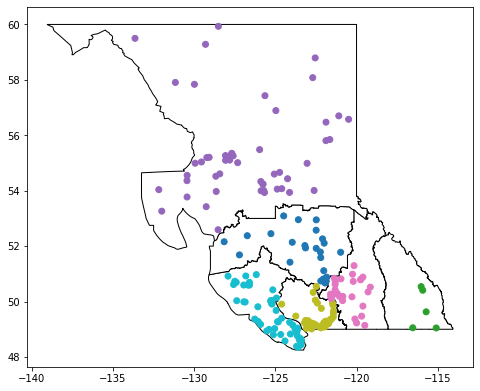

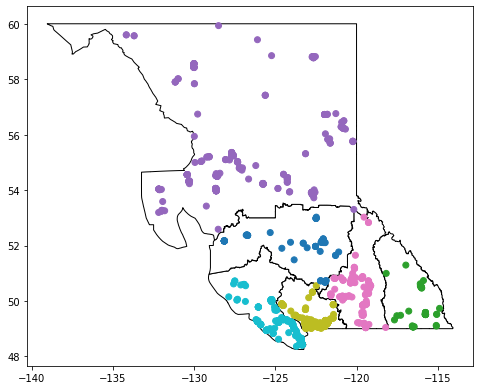

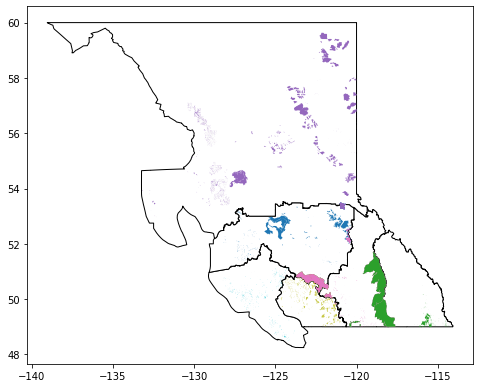

In [21]:
import matplotlib.pyplot as plt

region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
for layer in layers.keys():
    gdf = gpd.read_file(layers[layer])
    gdf_region = gpd.sjoin(gdf, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
    gdf_region.to_file(f"../data/processed/{layers[layer].split('/')[3].split('.')[0]}"+"_region.geojson", driver="GeoJSON")
    
    fig, ax = plt.subplots(figsize =(5,5))
    region.plot(ax=ax, color='white', edgecolor='black')
    gdf_region.plot(ax=ax, column='TOURISM_REGION_NAME')

    plt.show()
    

In [30]:
## Wildlife layer needs extra step of dividing polygons first before spatial join
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
wildlife_raw= gpd.read_file('../data/raw/WCP_WILDLIFE_HABITAT_AREA_POLY.geojson')

In [ ]:
### Separate multipolygons into individual polygons to be able to cut by country
def divide_multipolygons(gdf):
    df = pd.DataFrame()
    for line in range(len(gdf)):
        if type(gdf.iloc[line]['geometry']) == shapely.geometry.polygon.Polygon:
            merge = gdf.iloc[[line],:]
            df = df.append(merge)  
        else:
            shapes = list(gdf.iloc[line]['geometry'])
            other_data = gdf.iloc[[line],gdf.columns != 'geometry']

            for i in range(len(shapes)):
                merge = pd.DataFrame(data=other_data)
                merge['geometry'] = shapes[i]
                df = df.append(merge)
    return df

In [44]:
#wildlife_split = divide_multipolygons(wildlife_raw)
#wsplit_region = gpd.sjoin(wildlife_split, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
wsplit_region.to_file('../data/processed/WCP_WILDLIFE_HABITAT_AREA_POLY_region.geojson', driver="GeoJSON")

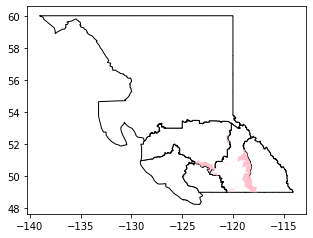

In [40]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='thompson_okanagan'].plot(ax=ax, color='pink')
plt.show()

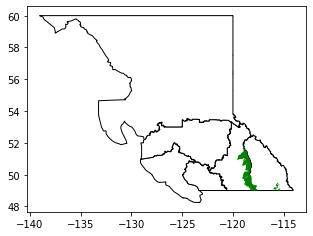

In [41]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='kootenay_rockies'].plot(ax=ax, color='green')
plt.show()

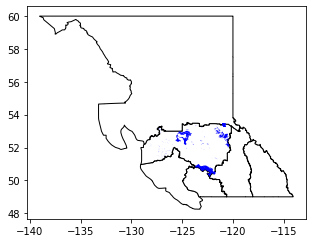

In [43]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='cariboo_chilcotin_coast'].plot(ax=ax, color='blue')
plt.show()

In [39]:
wsplit_region = gpd.sjoin(wildlife_spli, region[['TOURISM_REGION_NAME','geometry']], how ='inner')

# Create mbtiles

In [15]:
layer_name = "tourism_regions"
source_path = "../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson"
dest_path = "../data/tourism_regions.mbtiles"
create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

Processing: tippecanoe -o ../data/tourism_regions.mbtiles -l tourism_regions -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/ADM_TOURISM_REGIONS_SP_newname.geojson
Task created
Finished processing


In [16]:
layer_name = "ski_resorts"
source_path = "../data/processed/GSR_SKI_RESORTS_SV_region.geojson"
dest_path = "../data/processed/ski_resorts.mbtiles"
create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

Processing: tippecanoe -o ../data/ski_resorts.mbtiles -l ski_resorts -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/GSR_SKI_RESORTS_SV_region.geojson
Task created
Finished processing


In [48]:
mbtiles= {'ski_resorts': {'source':'../data/processed/GSR_SKI_RESORTS_SV_region.geojson', 
                                   'dest':'../data/processed/ski_resorts.mbtiles'},
         'first_nations_communities':{'source':'../data/processed/FN_COMMUNITY_LOCATIONS_SP_region.geojson',
                                      'dest':'../data/processed/first_nations_communities.mbtiles'},
         'first_nations_business':{'source':'../data/processed/GSR_INDIGENOUS_BUSINESSES_SV_region.geojson',
                                   'dest':'../data/processed/first_nations_business.mbtiles'},
         'wildlife_habitats':{'source':'../data/processed/WCP_WILDLIFE_HABITAT_AREA_POLY_region.geojson',
                             'dest':'../data/processed/wildlife_habitats.mbtiles'}}

In [52]:
mbtiles['ski_resorts']['source']

'../data/processed/GSR_SKI_RESORTS_SV_region.geojson'

In [53]:
for layer in mbtiles.keys():
    layer_name = layer
    source_path = mbtiles[layer]['source']
    dest_path = mbtiles[layer]['dest']
    create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")
    

Processing: tippecanoe -o ../data/processed/ski_resorts.mbtiles -l ski_resorts -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/GSR_SKI_RESORTS_SV_region.geojson
Task created
Finished processing
Processing: tippecanoe -o ../data/processed/first_nations_communities.mbtiles -l first_nations_communities -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/FN_COMMUNITY_LOCATIONS_SP_region.geojson
Task created
Finished processing
Processing: tippecanoe -o ../data/processed/first_nations_business.mbtiles -l first_nations_business -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/GSR_INDIGENOUS_BUSINESSES_SV_region.geojson
Task created
Finished processing
Processing: tippecanoe -o ../data/processed/wildlife_habitats.mbtiles -l wildlife_habitats -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../dat

### Upload thorugh [Mapbox Studio]( https://studio.mapbox.com/tilesets/) or Mapbox API
